In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV
import csv
import nltk
from nltk.stem import WordNetLemmatizer
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

In [35]:
df1 = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=['review','score'])
print("Loaded %s reviews from amazon." % df1.shape[0])
df2 = pd.read_csv('yelp_labelled.txt', sep='\t', names=['review','score'])
print("Loaded %s reviews from yelp." % df2.shape[0])
df3 = pd.read_csv('imdb_labelled.txt', sep='\t', names=['review','score'], quoting=csv.QUOTE_NONE)
print("Loaded %s reviews from imdb." % df3.shape[0])
df = pd.concat([df1,df2,df3])
score_count = df.score.value_counts()
print("Observations with score 0: "+str(score_count.loc[0]))
print("Observations with score 1: "+str(score_count.loc[1]))

Loaded 1000 reviews from amazon.
Loaded 1000 reviews from yelp.
Loaded 1000 reviews from imdb.
Observations with score 0: 1500
Observations with score 1: 1500


In [36]:
df.review = df.review.str.lower()
df.review = df.review.str.replace("[-.,?!`' ]+", ' ')
df.review = df.review.str.replace(' the ', ' ')
df.review = df.review.str.replace(' and ', ' ')
df.review = df.review.str.replace(' or ', ' ')
df.review = df.review.str.replace(' a ', ' ')
df.review = df.review.str.replace(' an ', ' ')
df.review = df.review.str.replace(' to ', ' ')

C:\Users\Romain\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


### Lemmatization with NLTK
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [37]:
def lemmatize(sentence, lemmatizer):
    word_list = sentence.strip().split(" ")
    return [lemmatizer.lemmatize(word) for word in word_list]

lemmatizer = WordNetLemmatizer()
df.review = df.review.apply(lemmatize, args=[lemmatizer])
print(df.review.iloc[0])

['so', 'there', 'is', 'no', 'way', 'for', 'me', 'plug', 'it', 'in', 'here', 'in', 'u', 'unless', 'i', 'go', 'by', 'converter']


In [5]:
df1 = df.iloc[:1000]
df2 = df.iloc[1000:2000]
df3 = df.iloc[2000:]

df_list = [df1, df2, df3]

def split_train_test(df):
    return (pd.concat([df[df["score"] == 0].iloc[:400],df[df["score"] == 1].iloc[:400]]),
            pd.concat([df[df["score"] == 0].iloc[400:],df[df["score"] == 1].iloc[400:]]))

train_list = []
test_list = []

for dfi in df_list:
    train, test = split_train_test(dfi)
    train_list.append(train)
    test_list.append(test)
    
df_train = pd.concat(train_list).reset_index(drop=True)
df_test = pd.concat(test_list).reset_index(drop=True)
print('We split the data into %s train reviews and %s test reviews.' % (df_train.shape[0], df_test.shape[0]))

We split the data into 2400 train reviews and 600 test reviews.


In [6]:
def build_feat_matrix(count, df):
    feat_matrix = []
    for row in df.review.array:
        feat_vec = []
        for word in count.keys():
            if word in row:
                feat_vec.append(row.count(word))
            else:
                feat_vec.append(0)
        feat_matrix.append(feat_vec)

    return np.array(feat_matrix)

def bag_of_words(df_train, df_test):
    count = {}

    # First pass to count every word of train reviews in dictionary
    for row in df_train.review.array:
        for word in row:
            if word not in count and len(word) > 1:
                count[word] = 1
            if word in count:
                count[word] += 1

    words = []
    for word in count.keys():
        words.append(word)

    # Second pass to build feature vectors of train and test
    feat_matrix_train = build_feat_matrix(count, df_train)
    feat_matrix_test = build_feat_matrix(count, df_test)
    
    return count, words, feat_matrix_train, feat_matrix_test

count, words, feat_matrix_train, feat_matrix_test = bag_of_words(df_train, df_test)
print("Here is a vector (%s features):" % feat_matrix_train.shape[1])
print(feat_matrix_train[666])
print("\nand here is another vector:")
print(feat_matrix_train[420])

Here is a vector (4400 features):
[0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Post-processing
We will standardize the data so that it is fit to apply Ridge and Lasso regularization in later questions.

In [7]:
def standardize(feat_matrix_train, feat_matrix_test):
    feat_matrix_train_std = np.empty(shape=feat_matrix_train.shape)
    feat_matrix_test_std = np.empty(shape=feat_matrix_test.shape)

    for col in range(feat_matrix_train.shape[1]):
        mean = feat_matrix_train[:,col].mean()
        std = feat_matrix_train[:,col].std()
        feat_matrix_train_std[:,col] = (feat_matrix_train[:,col] - mean)/std
        feat_matrix_test_std[:,col] = (feat_matrix_test[:,col] - mean)/std
        
    return feat_matrix_train_std, feat_matrix_test_std

feat_matrix_train_std, feat_matrix_test_std = standardize(feat_matrix_train, feat_matrix_test)

df_train = pd.concat([df_train, pd.DataFrame(feat_matrix_train_std)], axis=1)
df_test = pd.concat([df_test, pd.DataFrame(feat_matrix_test_std)], axis=1)

print("The mean of the resulting columns is almost 0 (here are the first 10):")
print(feat_matrix_train_std.mean(axis=0)[:10])

The mean of the resulting columns is almost 0 (here are the first 10):
[-4.73047527e-16  1.30756517e-15  8.54177840e-16  2.19824159e-16
  4.99415324e-16 -2.31527760e-16 -1.28138241e-17  7.43895686e-16
  1.77644936e-15 -1.29928475e-15]


### Naive Bayes Classifier
This is a conditional probability classifier: we want to estimate the following

$$\mathbb{P}[Y=1|X=x] = \frac{\mathbb{P}[Y=1]\mathbb{P}[X=x|Y=1]}{\mathbb{P}[X=x|Y=1]\mathbb{P}[Y=1]+\mathbb{P}[X=x|Y=0]\mathbb{P}[Y=0]}$$

Because the scores are balanced (1500 observations with score of 1, and 1500 observations with score of 0) we have that $\hat{\mathbb{P}}[Y=1] = \hat{\mathbb{P}}[Y=0] = 0.5$ and we can simplify the above:

$$\hat{\mathbb{P}}[Y=1|X=x] = \frac{\hat{\mathbb{P}}[X=x|Y=1]}{\hat{\mathbb{P}}[X=x|Y=1]+\hat{\mathbb{P}}[X=x|Y=0]}$$

But it is hard to estimate $\hat{\mathbb{P}}[X=x|Y=y]$ for a number of features p large. So by taking the naive conditional independance assumption, we can focus on computing the following:

$$\frac{\prod_{i=1}^p\hat{\mathbb{P}}[X_i=x_i|Y=1]}{\prod_{i=1}^p\hat{\mathbb{P}}[X_i=x_i|Y=1]+\prod_{i=1}^p\hat{\mathbb{P}}[X_i=x_i|Y=0]}$$

We will build 2 dictionaries, to estimate $\hat{\mathbb{P}}[X_i=x_i|Y=j]$, one for $j=0$ and one for $j=1$. In each of these dictionaries we will link a key $X_i$ for the column evaluated and as value a dictionary counting the estimated probability that we target.
In each dictionary the key will correspond to $x_i$ the (standardized) count of the ith word in the feature vector, and the value will be $\hat{\mathbb{P}}[X_i=x_i|Y=j]$ for each $x_i$.

In [8]:
class NaiveBayes:
    def __init__(self):
        self.probXgivenY1 = {}
        self.probXgivenY0 = {}
        self.y_pred = None
        return
    
    def fit(self, X_train, y_train, alpha=0.2):
        for col in X_train.columns:
            probXigivenY0={}
            probXigivenY1={}
            for value in X_train[col].unique():
                probXigivenY0[value] = (X_train[col][(X_train[col] == value) & (y_train.astype(int) == 0)].shape[0]+alpha) / (X_train.shape[0]/2+alpha)
                probXigivenY1[value] = (X_train[col][(X_train[col] == value) & (y_train.astype(int) == 1)].shape[0]+alpha) / (X_train.shape[0]/2+alpha)
            self.probXgivenY0[col] = probXigivenY0
            self.probXgivenY1[col] = probXigivenY1
            
        return
        
    def predict(self, X_test):
        if self.y_pred != None:
            return self.y_pred
        
        matrixProbXgivenY1 = np.empty(shape=X_test.shape)
        matrixProbXgivenY0 = np.empty(shape=X_test.shape)
        for col in range(X_test.shape[1]):
            matrixProbXgivenY1[:,col] = X_test.iloc[:,col].map(self.probXgivenY1[col])
            matrixProbXgivenY0[:,col] = X_test.iloc[:,col].map(self.probXgivenY0[col])
        
        numerator = np.product(matrixProbXgivenY1, axis=1)
        denominator = numerator + np.product(matrixProbXgivenY0, axis=1)
        
        output = numerator / denominator
        
        return (output > 0.5).astype(int)
    

In [9]:
naiveBayes = NaiveBayes()
naiveBayes.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_nb = naiveBayes.predict(df_test.iloc[:,2:])

In [10]:
print("Accuracy of Naive Bayes: %s"%accuracy_score(df_test["score"], y_pred_nb))

Accuracy of Naive Bayes: 0.7783333333333333


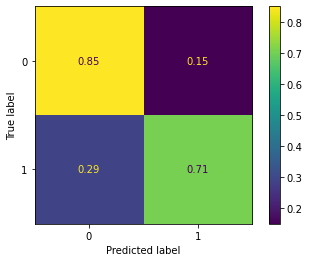

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix(df_test["score"], y_pred_nb, normalize="true"))
disp.plot()
plt.show()

### Logistic Regression

In [12]:
logRegL1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logRegL1.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_L1 = logRegL1.predict(df_test.iloc[:,2:])

print("Accuracy of logistic regression with Lasso: %s"%accuracy_score(df_test["score"],y_pred_L1))

Accuracy of logistic regression with Lasso: 0.8183333333333334


In [13]:
logRegL2 = LogisticRegressionCV(penalty='l2')
logRegL2.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_L2 = logRegL2.predict(df_test.iloc[:,2:])

print("Accuracy of logistic regression with Ridge: %s"%accuracy_score(df_test["score"],y_pred_L2))

Accuracy of logistic regression with Ridge: 0.7983333333333333


In [14]:
print("# of non-zero coefficients w. Lasso: %s"%np.count_nonzero(logRegL1.coef_))
print("# of non-zero coefficients w. Ridge: %s"%np.count_nonzero(logRegL2.coef_))

# of non-zero coefficients w. Lasso: 1436
# of non-zero coefficients w. Ridge: 4400


In [15]:
print("Top 10 words with lowest coefficients given Lasso:")
i=1
for idx in np.argsort(logRegL1.coef_[0])[:10]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1
    
print("\nTop 10 words with lowest coefficients given Ridge:")
i=1
for idx in np.argsort(logRegL2.coef_[0])[:10]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1

Top 10 words with lowest coefficients given Lasso:
1. not
2. bad
3. poor
4. sucked
5. worst
6. doesn
7. disappointment
8. never
9. didn
10. no

Top 10 words with lowest coefficients given Ridge:
1. not
2. bad
3. poor
4. worst
5. terrible
6. waste
7. awful
8. horrible
9. slow
10. didn


In [16]:
print("Top 10 words with higest coefficients given Lasso:")
i=1
for idx in np.argsort(logRegL1.coef_[0])[:-11:-1]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1
    
print("\nTop 10 words with higest coefficients given Ridge:")
i=1
for idx in np.argsort(logRegL2.coef_[0])[:-11:-1]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1

Top 10 words with higest coefficients given Lasso:
1. great
2. good
3. love
4. best
5. nice
6. excellent
7. well
8. watch
9. delicious
10. 15

Top 10 words with higest coefficients given Ridge:
1. great
2. good
3. love
4. excellent
5. nice
6. delicious
7. best
8. fantastic
9. awesome
10. price


### 2-grams

In [38]:
df.review = df.review.apply(lambda x: list(nltk.ngrams(x,2)))
df.review

0      [(so, there), (there, is), (is, no), (no, way)...
1      [(good, case), (case, excellent), (excellent, ...
2                         [(great, for), (for, jawbone)]
3      [(tied, charger), (charger, for), (for, conver...
4                   [(the, mic), (mic, is), (is, great)]
                             ...                        
995    [(i, just), (just, got), (got, bored), (bored,...
996    [(unfortunately, any), (any, virtue), (virtue,...
997    [(in, word), (word, it), (it, is), (is, embarr...
998                               [(exceptionally, bad)]
999    [(all, in), (in, all), (all, it), (it, insult)...
Name: review, Length: 3000, dtype: object

In [39]:
df1 = df.iloc[:1000]
df2 = df.iloc[1000:2000]
df3 = df.iloc[2000:]

df_list = [df1, df2, df3]

train_list = []
test_list = []

for dfi in df_list:
    train, test = split_train_test(dfi)
    train_list.append(train)
    test_list.append(test)
    
df_train = pd.concat(train_list).reset_index(drop=True)
df_test = pd.concat(test_list).reset_index(drop=True)
print('We split the data into %s train reviews and %s test reviews.' % (df_train.shape[0], df_test.shape[0]))

We split the data into 2400 train reviews and 600 test reviews.


In [40]:
count, words, feat_matrix_train, feat_matrix_test = bag_of_words(df_train, df_test)
feat_matrix_train_std, feat_matrix_test_std = standardize(feat_matrix_train, feat_matrix_test)
df_train = pd.concat([df_train, pd.DataFrame(feat_matrix_train_std)], axis=1)
df_test = pd.concat([df_test, pd.DataFrame(feat_matrix_test_std)], axis=1)

Accuracy of Naive Bayes: 0.7366666666666667


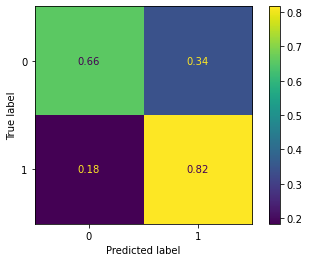

In [41]:
naiveBayes = NaiveBayes()
naiveBayes.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_nb = naiveBayes.predict(df_test.iloc[:,2:])
print("Accuracy of Naive Bayes: %s"%accuracy_score(df_test["score"], y_pred_nb))
disp = ConfusionMatrixDisplay(confusion_matrix(df_test["score"], y_pred_nb, normalize="true"))
disp.plot()
plt.show()

In [43]:
logRegL1 = LogisticRegressionCV(penalty='l1', solver='liblinear')
logRegL1.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_L1 = logRegL1.predict(df_test.iloc[:,2:])

print("Accuracy of logistic regression with Lasso: %s"%accuracy_score(df_test["score"],y_pred_L1))

Accuracy of logistic regression with Lasso: 0.6766666666666666


In [42]:
logRegL2 = LogisticRegressionCV(penalty='l2')
logRegL2.fit(df_train.iloc[:,2:], df_train["score"])
y_pred_L2 = logRegL2.predict(df_test.iloc[:,2:])

print("Accuracy of logistic regression with Ridge: %s"%accuracy_score(df_test["score"],y_pred_L2))

Accuracy of logistic regression with Ridge: 0.725


In [44]:
print("Top 10 words with lowest coefficients given Lasso:")
i=1
for idx in np.argsort(logRegL1.coef_[0])[:10]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1
    
print("\nTop 10 words with lowest coefficients given Ridge:")
i=1
for idx in np.argsort(logRegL2.coef_[0])[:10]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1
    
print("\nTop 10 words with higest coefficients given Lasso:")
i=1
for idx in np.argsort(logRegL1.coef_[0])[:-11:-1]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1
    
print("\nTop 10 words with higest coefficients given Ridge:")
i=1
for idx in np.argsort(logRegL2.coef_[0])[:-11:-1]:
    print("%s. %s"%(i, words[int(idx)]))
    i+=1

Top 10 words with lowest coefficients given Lasso:
1. ('very', 'disappointed')
2. ('wa', 'terrible')
3. ('so', 'bad')
4. ('not', 'good')
5. ('not', 'impressed')
6. ('is', 'terrible')
7. ('very', 'disappointing')
8. ('not', 'work')
9. ('not', 'recommend')
10. ('poor', 'quality')

Top 10 words with lowest coefficients given Ridge:
1. ('not', 'good')
2. ('would', 'not')
3. ('wa', 'terrible')
4. ('very', 'disappointed')
5. ('not', 'recommend')
6. ('very', 'disappointing')
7. ('don', 't')
8. ('waste', 'of')
9. ('is', 'terrible')
10. ('do', 'not')

Top 10 words with higest coefficients given Lasso:
1. ('work', 'great')
2. ('love', 'this')
3. ('great', 'phone')
4. ('great', 'product')
5. ('great', 'food')
6. ('wa', 'delicious')
7. ('very', 'comfortable')
8. ('work', 'well')
9. ('wa', 'very')
10. ('good', 'price')

Top 10 words with higest coefficients given Ridge:
1. ('work', 'great')
2. ('love', 'this')
3. ('great', 'phone')
4. ('very', 'good')
5. ('is', 'great')
6. ('i', 'love')
7. ('is', '